In [12]:
# ------------------------------------------------------------------------
# Library imports
# ------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sqlite3
import json
import statsmodels.api as sm
from lmfit.model import Model, save_modelresult, load_modelresult
from lmfit.models import LinearModel
from lmfit import minimize, Parameters, create_params
import scipy.constants as sc
import matplotlib as mpl
import os

NERD_SQLITE = '../../../Core_nerd_analysis/nerd.sqlite'

# ------------------------------------------------------------------------
# Global plotting configuration
# ------------------------------------------------------------------------
# set font size
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [13]:
def fetch_tc_fit_params(db_path, selected_construct, selected_site_base, selected_valtype_tc = 'modrate'):
    """
    Fetch fitted time-course parameters for a specific rg_id, site_base, and valtype.
    
    Parameters
    ----------
    db_path : str
        Path to the SQLite database file.
    selected_construct : str
        Construct disp_name
    selected_site_base : str
        Site and base combination (e.g., '18_A', '25_C').
    selected_valtype_tc : str
        Value type for filtering (e.g., 'modrate').

    Returns
    -------
    pd.DataFrame
        DataFrame containing fitted parameters with columns: fit_run_id, log_kobs,
        log_kdeg, log_fmod0, kobs, kdeg, fmod0, log_kobs_err, log_kdeg_err,
        log_fmod0_err, diag_r2.
    """

    conn = sqlite3.connect(db_path)
    fitted_params_df = pd.read_sql_query(
        """
        WITH run AS (
            SELECT id AS fit_run_id, rg_id
            FROM probe_tc_fit_runs
            WHERE (rg_id, nt_id) IN (
                SELECT DISTINCT pr.rg_id, mn.id
                FROM probe_reactions pr
                JOIN probe_fmod_values fv ON fv.rxn_id = pr.id
                JOIN meta_nucleotides mn ON mn.id = fv.nt_id
                JOIN meta_constructs mc ON mc.id = pr.construct_id
                WHERE mc.disp_name = :selected_construct
                AND mn.site || '_' || UPPER(mn.base) = :site_base
            )
            AND fit_kind = 'round3_constrained'
            AND valtype = :valtype_mod
        )
        SELECT
            p.fit_run_id,
            r.rg_id,
            pr.temperature,
            pr.replicate,
            MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')
                    THEN p.param_numeric END) AS log_kappa,
            MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                    THEN p.param_numeric END) AS log_kdeg,
            MAX(CASE WHEN p.param_name IN ('log_fmod0','logfmod0')
                    THEN p.param_numeric END) AS log_fmod0,
            MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')
                    THEN p.param_numeric END) AS log_kappa_err,
            MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                    THEN p.param_numeric END) AS log_kdeg_err,
            MAX(CASE WHEN p.param_name IN ('log_fmod0_err','logfmod0_err')
                    THEN p.param_numeric END) AS log_fmod0_err,
            MAX(CASE WHEN p.param_name = 'diag:r2'
                    THEN p.param_numeric END) AS r2
        FROM probe_tc_fit_params p
        JOIN run r
            ON r.fit_run_id = p.fit_run_id
        JOIN probe_reactions pr
            ON pr.rg_id = r.rg_id
        GROUP BY
            p.fit_run_id,
            r.rg_id,
            pr.temperature,
            pr.replicate
        ORDER BY
            pr.temperature ASC,
            pr.replicate ASC;
        """,
        conn,
        params={"selected_construct": selected_construct, "site_base": selected_site_base, "valtype_mod": selected_valtype_tc},
    )
    conn.close()
    return fitted_params_df

def fetch_global_kdeg(db_path, selected_rg_id):
    """
    Fetch fitted time-course parameters for a specific rg_id, site_base, and valtype.
    
    Parameters
    ----------
    db_path : str
        Path to the SQLite database file.
    selected_construct : str
        Construct disp_name
    selected_site_base : str
        Site and base combination (e.g., '18_A', '25_C').
    selected_valtype_tc : str
        Value type for filtering (e.g., 'modrate').

    Returns
    -------
    pd.DataFrame
        DataFrame containing fitted parameters with columns: fit_run_id, log_kobs,
        log_kdeg, log_fmod0, kobs, kdeg, fmod0, log_kobs_err, log_kdeg_err,
        log_fmod0_err, diag_r2.
    """

    conn = sqlite3.connect(db_path)
    global_fit_params_df = pd.read_sql_query(
        """
        SELECT
            MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                    THEN p.param_numeric END) AS log_kdeg,
            MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                    THEN p.param_numeric END) AS log_kdeg_err
        FROM probe_tc_fit_params p
        JOIN probe_tc_fit_runs r
            ON r.id = p.fit_run_id
        JOIN probe_reactions pr
            ON pr.rg_id = r.rg_id
        WHERE r.rg_id = :selected_rg_id
        AND r.fit_kind = 'round2_global'

        GROUP BY
            p.fit_run_id,
            r.rg_id,
            pr.temperature,
            pr.replicate
        HAVING
            log_kdeg IS NOT NULL
        ORDER BY
            pr.temperature ASC,
            pr.replicate ASC
        """,
        conn,
        params={"selected_rg_id": selected_rg_id},
    )
    conn.close()
    return global_fit_params_df

In [14]:
# Load kadd arrhenius params for fourU
arrhenius_kadd_df = pd.read_csv('../../Figure2_ProbeKinetics/Add_Arrhenius/Arrhenius_fit_params_4U_AC.csv')

def get_kadd(arrhenius_kadd_df, group, temp_C):
    """Calculate kadd at a given temperature using Arrhenius parameters given in kcal/mol."""
    R = sc.R / sc.calorie / 1000  # Gas constant in kcal/(mol·K) - 0.001987
    T = temp_C + 273.15  # Convert to Kelvin
    row = arrhenius_kadd_df[arrhenius_kadd_df['group'] == group].iloc[0]
    A = np.exp(row['lnA'])
    Ea = row['ea']
    kadd = A * np.exp(-Ea / (R * T))
    return kadd

def get_lnkaddP0_slope_int(arrhenius_kadd_df, group, conc_DMS):
    """Get slope and intercept of ln(kadd) vs 1/T for a given group."""
    R = sc.R / sc.calorie / 1000  # Gas constant in kcal/(mol·K)
    row = arrhenius_kadd_df[arrhenius_kadd_df['group'] == group].iloc[0]
    slope = -row['ea'] / R  # in K
    intercept = row['lnA'] + np.log(conc_DMS)
    return slope, intercept

# Calculate kadd for melted_agg_A at 25C with concentration
conc_DMS = 0.015852692  # in M, 1.5% v/v
kadd_A = get_kadd(arrhenius_kadd_df, 'melted_agg_A', 25) * conc_DMS
kadd_C = get_kadd(arrhenius_kadd_df, 'melted_agg_C', 25) * conc_DMS

print(f'kadd_A at 25C: {kadd_A} M^-1 s^-1')
print(f'kadd_C at 25C: {kadd_C} M^-1 s^-1')

kadd_A_params = get_lnkaddP0_slope_int(arrhenius_kadd_df, 'melted_agg_A', conc_DMS)
kadd_C_params = get_lnkaddP0_slope_int(arrhenius_kadd_df, 'melted_agg_C', conc_DMS)

kadd_A at 25C: 4.135706316149028e-05 M^-1 s^-1
kadd_C at 25C: 7.215254960091898e-05 M^-1 s^-1


In [61]:
def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

import numpy as np

def safe_frac(invT, dH_fold, Tm, R=1.987e-3, clip_logK=50.0, eps=1e-12):
    """
    invT     : 1/T in K^-1  (your x)
    dH_fold  : kcal/mol
    Tm       : °C (as in your current code)
    R        : kcal/(mol·K)
    """

    invT = np.asarray(invT)

    # Convert Tm to Kelvin
    TmK = Tm + 273.15

    # logK1 = (dH/R) * (1/Tm - 1/T) = (dH/R) * (1/TmK - invT)
    logK1 = (dH_fold / R) * (1.0 / TmK - invT)

    # Clip to avoid huge exponents in the logistic
    logK1 = np.clip(logK1, -clip_logK, clip_logK)

    # Stable logistic: fracf = 1 / (1 + exp(-logK1))
    fracf = 1.0 / (1.0 + np.exp(-logK1))
    fracu = 1.0 - fracf

    # If you ever reintroduce logs, avoid exact 0 or 1
    fracf = np.clip(fracf, eps, 1.0 - eps)
    fracu = np.clip(fracu, eps, 1.0 - eps)

    return fracu, fracf

def melt_fit(x, upper_m, upper_b, lower_m, lower_b, dH_fold, Tm):
    # upper_m: slope of the unfolded state
    # upper_b: y-intercept of the unfolded state
    # lower_m: slope of the folded state
    # lower_b: y-intercept of the folded state
    # dH_fold: energy of the transition state
    # Tm: temperature of the transition state
    
    temp = 1 / x

    R = sc.R / sc.calorie / 1000  # Gas constant in kcal/(mol·K)

    fracu, fracf = safe_frac(x, dH_fold, Tm, R=R)
    basef = lower_m * x + lower_b
    baseu = upper_m * x + upper_b

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

def fit_meltcurve(x, y, kadd_params = None, init_params = None):
    # Make sure x is sorted

    # Guess top baseline
    model = LinearModel()
    params = model.guess(y.iloc[:3], x = x.iloc[:3])
    top_fit = model.fit(y.iloc[:3], params, x = x.iloc[:3])
    init_upper_m = top_fit.params['slope'].value
    init_upper_b = top_fit.params['intercept'].value

    # Guess bottom baseline
    params = model.guess(y.iloc[-3:], x = x.iloc[-3:])
    bot_fit = model.fit(y.iloc[-3:], params, x = x.iloc[-3:])
    init_lower_m = bot_fit.params['slope'].value
    init_lower_b = bot_fit.params['intercept'].value
    
    # Set initial params
    if init_params is not None:
        tm_max = init_params.get('Tm_max', tm_max)
        tm_min = init_params.get('Tm_min', tm_min)
        init_tm = init_params.get('Tm', tm)
        init_dH_fold = init_params.get('dH_fold', dH_fold)
    else:
        tm_max = 60
        tm_min = 0
        init_tm = 42
        init_dH_fold = -60 

    # Set up fit model
    melt_model = Model(melt_fit)
    melt_params = melt_model.make_params(upper_m = init_upper_m, upper_b = init_upper_b, lower_m = init_lower_m, lower_b = init_lower_b, dH_fold = init_dH_fold, Tm = init_tm)
    
    melt_params['Tm'].vary = True
    melt_params['Tm'].max = tm_max
    melt_params['Tm'].min = tm_min
    
    # Use kadd_params from Arrhenius fit if provided
    if kadd_params is not None:
        # lock to kadd_params
        kadd_slope, kadd_intercept = kadd_params
        melt_params['upper_m'].value = kadd_slope
        melt_params['upper_b'].value = kadd_intercept
        melt_params['upper_m'].vary = False
        melt_params['upper_b'].vary = False

    # Perform actual fit
    melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)

    return melt_result

In [62]:
def apply_2state(site, construct, lnkadd_params, db_path=NERD_SQLITE):

    # Fetch fit params (kobs, kdeg, etc.)
    fit_params_df = fetch_tc_fit_params(db_path, construct, site)

    # Filter QC and/or outliers
    fit_params_df = fit_params_df[fit_params_df['r2'] > 0.3]
    # # filter outliers (for 25_C A8C)
    fit_params_df = fit_params_df[~fit_params_df['rg_id'].isin([9, 10, 21, 32, 33])]

    # drop fit_run_id 24229 (for 8_C A8C)
    fit_params_df = fit_params_df[fit_params_df['fit_run_id'] != 24229]
    # Calculate 1/T, log_kobs, and log_kobs_err
    fit_params_df['1/T'] = 1 / (fit_params_df['temperature'] + 273.15)
    fit_params_df['log_kobs'] = fit_params_df['log_kappa'] + fit_params_df['log_kdeg']
    fit_params_df['log_kobs_err'] = np.sqrt(fit_params_df['log_kappa_err']**2 + fit_params_df['log_kdeg_err']**2)

    # Sort by 1/T
    fit_params_df = fit_params_df.sort_values(by='1/T')

    fit_result = fit_meltcurve(fit_params_df['1/T'], fit_params_df['log_kobs'], kadd_params = lnkadd_params)

    return fit_result

In [88]:
to_fit = {'4U_wt': ['7_A', '8_A', '9_C', '15_A', '16_A', '22_A', '25_C', '26_A', '29_A', '34_A', '35_A'],
          '4U_a8c': ['7_A', '8_C', '9_C', '15_A', '16_A', '22_A', '25_C', '26_A', '29_A', '34_A', '35_A']}

kadd_params = {'A': kadd_A_params,
               'C': kadd_C_params}

# Make directory to store lmfit results (using save_modelresult)
os.makedirs('2state_fit_results', exist_ok=True)
rows = []

for construct, sites in to_fit.items():
    for site in sites:
        fit_result = apply_2state(site, construct, kadd_params[site[-1]])
        save_modelresult(fit_result, f'2state_fit_results/{construct}_{site}.sav')

        rows.append({
            'construct': construct,
            'site': site,
            'upper_m': fit_result.params['upper_m'].value,
            'upper_b': fit_result.params['upper_b'].value,
            'lower_m': fit_result.params['lower_m'].value,
            'lower_b': fit_result.params['lower_b'].value,
            'dH_fold': fit_result.params['dH_fold'].value,
            'Tm': fit_result.params['Tm'].value,
            'r2': fit_result.rsquared,
        })

params_df = pd.DataFrame.from_records(rows)
params_df.to_csv('2state_fit_results/all_fit_params.csv', index=False)

In [89]:
# Calculate kinetic parameters at a given temp

# Make directory to store
os.makedirs('kinetic_params_per_nt', exist_ok=True)

temp_C = 25.0

# Load ln(kadd) Arrhenius fits
lnkadd_A_linfit = load_modelresult('../../Figure2_ProbeKinetics/Add_Arrhenius/Arrhenius_fit_results/agg_4U_A_arrhenius_fit.sav')
lnkadd_C_linfit = load_modelresult('../../Figure2_ProbeKinetics/Add_Arrhenius/Arrhenius_fit_results/agg_4U_C_arrhenius_fit.sav')
lnkadd_linfits = {'A': lnkadd_A_linfit,
                  'C': lnkadd_C_linfit}

# Calculate kinetic parameters at temp_C
rows = []
for construct, sites in to_fit.items():
    for site in sites:

        # Load 2-state fit result
        fit_result = load_modelresult(f'2state_fit_results/{construct}_{site}.sav')
        lnkadd_fit = lnkadd_linfits[site[-1]]

        # Evaluate ln(kobs) and ln(kadd) at temp_C
        ln_kobs = fit_result.eval(x = 1/(temp_C + 273.15))
        ln_kobs_err = fit_result.eval_uncertainty(x = 1/(temp_C + 273.15))

        # Evaluate ln(kadd) at temp_C
        ln_kadd = lnkadd_fit.eval(x = 1/(temp_C + 273.15))
        ln_kadd_err = lnkadd_fit.eval_uncertainty(x = 1/(temp_C + 273.15))

        # Append results
        rows.append({
            'construct': construct,
            'site': site,
            'temp_C': temp_C,
            'ln_kobs': ln_kobs,
            'ln_kobs_err': ln_kobs_err,
            'ln_kadd': ln_kadd,
            'ln_kadd_err': ln_kadd_err,
        })

kinetic_params_df = pd.DataFrame.from_records(rows)
kinetic_params_df.to_csv(f'kinetic_params_per_nt/4U_kinetic_params_{temp_C:.0f}C.csv', index=False)

In [ ]:
# to use later
# Calculate smoothed best-fit values based on melt_result (for plotting)
def calc_smoothed_best_fit(melt_result):
    x = melt_result.userkws['x']
    x_data = np.linspace(min(x), max(x), 1000)
    y_data = melt_result.eval(x = x_data)
    return x_data, y_data

KeyError: 'c'

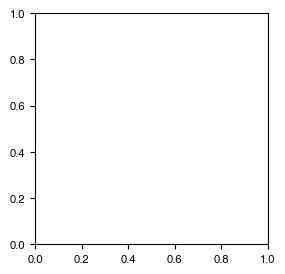

In [ ]:
smooth_x, smooth_y = calc_smoothed_best_fit(out)
kadd_curve_y = smooth_x * kadd_A_params[0] + kadd_A_params[1]
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
formatter = FuncFormatter(thousands)
lower_baseline = out.params['c'].value * smooth_x + out.params['d'].value

# plot 4U_wt
sns.scatterplot(data=fit_params_df, x='1/T', y='log_kobs', color='black', ax=ax)
ax.plot(smooth_x, smooth_y, color='black')
ax.plot(smooth_x, kadd_curve_y, color='darkgreen', alpha = 0.5) # upper baseline
ax.plot(smooth_x, lower_baseline, color='green', alpha = 0.5) # lower baseline
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{obs})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.annotate(f'{site}', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()